<div align="center">

# Steerable discovery of neural audio effects

  [Christian J. Steinmetz](https://www.christiansteinmetz.com/)  and  [Joshua D. Reiss](http://www.eecs.qmul.ac.uk/~josh/)


[Code](https://github.com/csteinmetz1/steerable-nafx) • [Paper](https://arxiv.org/abs/2112.02926) • [Demo](https://csteinmetz1.github.io/steerable-nafx)	• [Slides]()

<img src="https://csteinmetz1.github.io/steerable-nafx/assets/steerable-headline.svg">

</div>

## Abtract
Applications of deep learning for audio effects often focus on modeling analog effects or learning to control effects to emulate a trained audio engineer. 
However, deep learning approaches also have the potential to expand creativity through neural audio effects that enable new sound transformations. 
While recent work demonstrated that neural networks with random weights produce compelling audio effects, control of these effects is limited and unintuitive.
To address this, we introduce a method for the steerable discovery of neural audio effects.
This method enables the design of effects using example recordings provided by the user. 
We demonstrate how this method produces an effect similar to the target effect, along with interesting inaccuracies, while also providing perceptually relevant controls.


\* *Accepted to NeurIPS 2021 Workshop on Machine Learning for Creativity and Design*



# Setup

In [6]:
import sys
import math
import os
import torch
import onnx
import librosa.display
import IPython
import torchaudio
import torchinfo
import numpy as np
import scipy.signal
from tqdm.notebook import tqdm
from time import sleep
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [7]:
name = 'model_0'


if not os.path.exists('models/'+name):
    os.makedirs('models/'+name)
else:
    print("A model with the same name already exists. Please choose a new name.")
    exit

A model with the same name already exists. Please choose a new name.


In [8]:
def causal_crop(x, length: int):
  if x.shape[-1] != length:
    stop = x.shape[-1]

    start = stop - length
    x = x[..., start:stop]
  return x

class TCNBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, dilation, activation=True):
    super().__init__()
    self.conv = torch.nn.Conv1d(
        in_channels, 
        out_channels, 
        kernel_size, 
        dilation=dilation, 
        padding=0, #((kernel_size-1)//2)*dilation,
        bias=True)
    if activation:
      #self.act = torch.nn.Tanh()
      self.act = torch.nn.PReLU()
    # this is the residual connection with 1x1 conv to match the channels and mix the desired amount of residual in
    self.res = torch.nn.Conv1d(in_channels, out_channels, 1, bias=False)

  def forward(self, x):
    x_in = x
    x = self.conv(x)
    if hasattr(self, "act"):
      x = self.act(x)
    x_res = self.res(x_in)
    x_res = causal_crop(x_res, x.shape[-1])
    x = x + x_res

    return x

class TCN(torch.nn.Module):
  def __init__(self, n_inputs=1, n_outputs=1, n_blocks=10, kernel_size=13, n_channels=64, dilation_growth=4):
    super().__init__()
    self.kernel_size = kernel_size
    self.n_channels = n_channels
    self.dilation_growth = dilation_growth
    self.n_blocks = n_blocks
    self.stack_size = n_blocks

    self.blocks = torch.nn.ModuleList()
    for n in range(n_blocks):
      if n == 0:
        in_ch = n_inputs
        out_ch = n_channels
        act = True
      elif (n+1) == n_blocks:
        in_ch = n_channels
        out_ch = n_outputs
        act = True
      else:
        in_ch = n_channels
        out_ch = n_channels
        act = True
      
      dilation = dilation_growth ** n
      self.blocks.append(TCNBlock(in_ch, out_ch, kernel_size, dilation, activation=act))

  def forward(self, x):
    for block in self.blocks:
      x = block(x)

    return x
  
  def compute_receptive_field(self):
    """Compute the receptive field in samples."""
    rf = self.kernel_size
    for n in range(1, self.n_blocks):
        dilation = self.dilation_growth ** (n % self.stack_size)
        rf = rf + ((self.kernel_size - 1) * dilation)
    return rf

# 1. Steering (training)
Use a pair of audio examples in order to construct neural audio effects.

There are two options. Either start with the pre-loaded audio examples, or upload your own clean/processed audio recordings for the steering process.

a.) Use some of our pre-loaded audio examples. Choose from the compressor or reverb effect.

In [9]:
#@title Use pre-loaded audio examples for steering
effect_type = "Reverb" #@param ["Compressor", "Reverb"]

if effect_type == "Compressor":
  input_file = "audio/drum_kit_clean.wav"
  output_file = "audio/drum_kit_comp_agg.wav"
elif effect_type == "Reverb":
  input_file = "audio/acgtr_clean.wav"
  output_file = "audio/acgtr_reverb.wav"

x, sample_rate = torchaudio.load(input_file)
x = x[0:1,:]

y, sample_rate = torchaudio.load(output_file)
y = y[0:1,:]

print("input file", x.shape)
IPython.display.display(IPython.display.Audio(data=x, rate=sample_rate))
print("output file", y.shape)
IPython.display.display(IPython.display.Audio(data=y, rate=sample_rate))

input file torch.Size([1, 508032])


output file torch.Size([1, 508032])


Now its time to generate the neural audio effect by training the TCN to emulate the input/output function from the target audio effect. Adjusting the parameters will enable you to tweak the optimization process. 

In [10]:
#@title TCN model training parameters
kernel_size = 13 #@param {type:"slider", min:3, max:32, step:1}
n_blocks = 5 #@param {type:"slider", min:2, max:30, step:1}
dilation_growth = 8 #@param {type:"slider", min:1, max:10, step:1}
n_channels = 8 #@param {type:"slider", min:1, max:128, step:1}
n_iters = 500 #@param {type:"slider", min:0, max:10000, step:1}
length = 228308 #@param {type:"slider", min:0, max:524288, step:1}
lr = 0.001 #@param {type:"number"}

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

# reshape the audio
x_batch = x.view(1,x.shape[0],-1)
y_batch = y.view(1,y.shape[0],-1)

# crop to one channel
x_batch = x_batch[:,0:1,:]
y_batch = y_batch[:,0:1,:]

_, x_ch, x_samp = x_batch.size()
_, y_ch, y_samp = y_batch.size()

# build the model
model = TCN(
    n_inputs=x_ch,
    n_outputs=y_ch,
    kernel_size=kernel_size, 
    n_blocks=n_blocks, 
    dilation_growth=dilation_growth, 
    n_channels=n_channels)
rf = model.compute_receptive_field()
params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parameters: {params*1e-3:0.3f} k")
print(f"Receptive field: {rf} samples or {(rf/sample_rate)*1e3:0.1f} ms")

summary = torchinfo.summary(model, (1, 1, 228308), device=device)
print(summary)

print("The reduction in the first layer is from the kernel size. The reduction in the subsequent layers is from the dilation factor and kernel size.")

# setup loss function, optimizer, and scheduler
loss_fn_mse = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr)
ms1 = int(n_iters * 0.8)
ms2 = int(n_iters * 0.95)
milestones = [ms1, ms2]
print(
    "Learning rate schedule:",
    f"1:{lr:0.2e} ->",
    f"{ms1}:{lr*0.1:0.2e} ->",
    f"{ms2}:{lr*0.01:0.2e}",
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones,
    gamma=0.1,
    verbose=False,
)

# move tensors to GPU
if torch.cuda.is_available():
  model.to(device)
  x_batch = x_batch.to(device)
  y_batch = y_batch.to(device)

# pad input so that output is same size as input
x_pad = torch.nn.functional.pad(x_batch, (rf-1, 0))

Parameters: 2.950 k
Receptive field: 56173 samples or 1273.8 ms
Layer (type:depth-idx)                   Output Shape              Param #
TCN                                      [1, 1, 172136]            --
├─ModuleList: 1-1                        --                        --
│    └─TCNBlock: 2-1                     [1, 8, 228296]            --
│    │    └─Conv1d: 3-1                  [1, 8, 228296]            112
│    │    └─PReLU: 3-2                   [1, 8, 228296]            1
│    │    └─Conv1d: 3-3                  [1, 8, 228308]            8
│    └─TCNBlock: 2-2                     [1, 8, 228200]            --
│    │    └─Conv1d: 3-4                  [1, 8, 228200]            840
│    │    └─PReLU: 3-5                   [1, 8, 228200]            1
│    │    └─Conv1d: 3-6                  [1, 8, 228296]            64
│    └─TCNBlock: 2-3                     [1, 8, 227432]            --
│    │    └─Conv1d: 3-7                  [1, 8, 227432]            840
│    │    └─PReLU: 3-

In [11]:
########## iteratively update the weights

# this is only for the progress bar
pbar = tqdm(range(n_iters))

for n in pbar:
  optimizer.zero_grad()

  start_idx = rf #np.random.randint(rf, x_batch.shape[-1]-length-1)
  stop_idx = start_idx + length

  # the data is the same with every iteration
  x_crop = x_batch[...,start_idx-rf+1:stop_idx]
  y_crop = y_batch[...,start_idx:stop_idx]

  y_hat = model(x_crop)
  # loss_fn_l1(y_hat, y_crop)
  loss = loss_fn_mse(y_hat, y_crop)

  loss.backward()
  optimizer.step()
  
  scheduler.step()
  if (n+1) % 1 == 0:
    pbar.set_description(f" Loss: {loss.item():0.3e} | ")

y_hat /= y_hat.abs().max()

  0%|          | 0/500 [00:00<?, ?it/s]

Input shape: (508032,)
Output shape: (508032,)
Target shape: (508032,)
Input (clean)


Target


Output


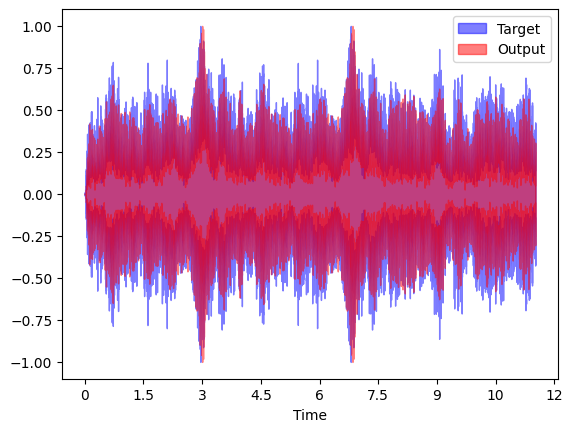

In [12]:
# needed because in the train we crop the target
model.eval()
x_pad = torch.nn.functional.pad(x_batch, (rf-1, 0))
with torch.no_grad():
  y_hat = model(x_pad)

input = causal_crop(x_batch.view(-1).detach().cpu().numpy(), y_hat.shape[-1])
output = y_hat.view(-1).detach().cpu().numpy()
target = causal_crop(y_batch.view(-1).detach().cpu().numpy(), y_hat.shape[-1])

print(f"Input shape: {input.shape}")
print(f"Output shape: {output.shape}")
print(f"Target shape: {target.shape}")

# apply highpass to outpu to remove DC
sos = scipy.signal.butter(8, 20.0, fs=sample_rate, output="sos", btype="highpass")
output = scipy.signal.sosfilt(sos, output)

input /= np.max(np.abs(input))
output /= np.max(np.abs(output))
target /= np.max(np.abs(target))

fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(target, sr=sample_rate, color='b', alpha=0.5, ax=ax, label='Target')
librosa.display.waveshow(output, sr=sample_rate, color='r', alpha=0.5, ax=ax, label='Output')

print("Input (clean)")
IPython.display.display(IPython.display.Audio(data=input, rate=sample_rate))
print("Target")
IPython.display.display(IPython.display.Audio(data=target, rate=sample_rate))
print("Output")
IPython.display.display(IPython.display.Audio(data=output, rate=sample_rate))
plt.legend()
plt.show(fig)

## 2. Processing sounds

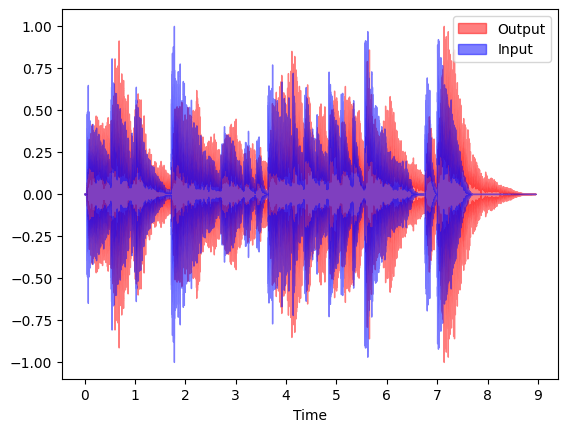

In [13]:
x_whole, sample_rate = torchaudio.load("audio/piano_clean.wav")

# Padding on both sides of the receptive field
x_whole = torch.nn.functional.pad(x_whole, (rf-1, rf-1))
x_whole = x_whole[0,:]
x_whole = x_whole.view(1,1,-1).to(device)

with torch.no_grad():
  y_whole = model(x_whole)

x_whole = causal_crop(x_whole, y_whole.shape[-1])

y_whole /= y_whole.abs().max()

# apply high pass filter to remove DC
sos = scipy.signal.butter(8, 20.0, fs=sample_rate, output="sos", btype="highpass")
y_whole = scipy.signal.sosfilt(sos, y_whole.cpu().view(-1).numpy())

x_whole = x_whole.view(-1).cpu().numpy()

y_whole = (y_whole * 0.8)
IPython.display.display(IPython.display.Audio(data=x_whole, rate=sample_rate))
IPython.display.display(IPython.display.Audio(data=y_whole, rate=sample_rate))

x_whole /= np.max(np.abs(x_whole))
y_whole /= np.max(np.abs(y_whole))

fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y_whole, sr=sample_rate, color='r', alpha=0.5, ax=ax, label='Output')
librosa.display.waveshow(causal_crop(x_whole, y_whole.shape[-1]), sr=sample_rate, alpha=0.5, ax=ax, label='Input', color="blue")
plt.legend()
plt.show(fig)


In [14]:
#torch.save(model, "./reverb_full.pt")
#torch.save(model, "./compressor_full.pt")
torch.save(model, "models/"+name+"/"+name+".pt")

# Export as pt model

In [15]:
batch_size_minimal = 2

In [16]:
# An example input you would normally provide to your model's forward() method.
example_x = torch.rand(batch_size_minimal, 1, length).to(device)

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example_inputs=example_x)
traced_script_module.save("models/"+name+"/"+name+"-traced-minimal.pt")

/tmp/ipykernel_31693/2241168452.py:2: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[-1] != length:


In [17]:
# An example input you would normally provide to your model's forward() method.
example_x = torch.rand(batch_size_minimal, 1, length).to(device)

filepath = "models/"+name+"/"+name+"-libtorch-traced"+"-minimal.onnx"

# Export the model
torch.onnx.export(model=model,
                  args=example_x,
                  f=filepath,
                  export_params=True,
                  opset_version=13,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'])

/tmp/ipykernel_31693/2241168452.py:2: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[-1] != length:
